In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Mall_Customers.csv')
# modify column name
df = df.rename(columns = {'Annual Income (k$)':'Annual Income',
                         'Spending Score (1-100)':'Spending Score'})

df.head()

,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [64]:
# CustomerID는 단순히 record 번호를 의미. clustering 하는데 필요X
# delete id
del df['CustomerID']

# Check the feature information of data
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
Gender            200 non-null object
Age               200 non-null int64
Annual Income     200 non-null int64
Spending Score    200 non-null int64
dtypes: int64(3), object(1)
memory usage: 6.3+ KB


,Age,Annual Income,Spending Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [65]:
# check the missing value
df.isnull().sum()

Gender            0
Age               0
Annual Income     0
Spending Score    0
dtype: int64

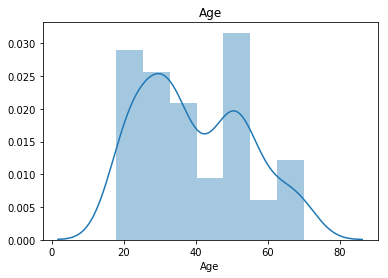

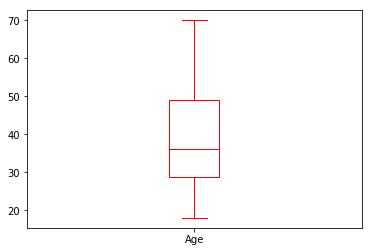

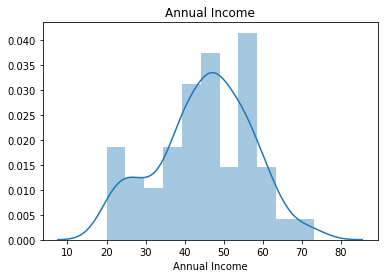

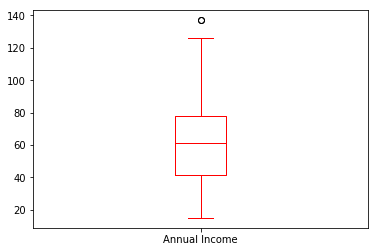

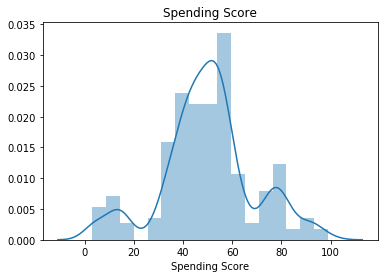

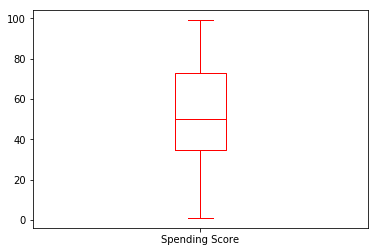

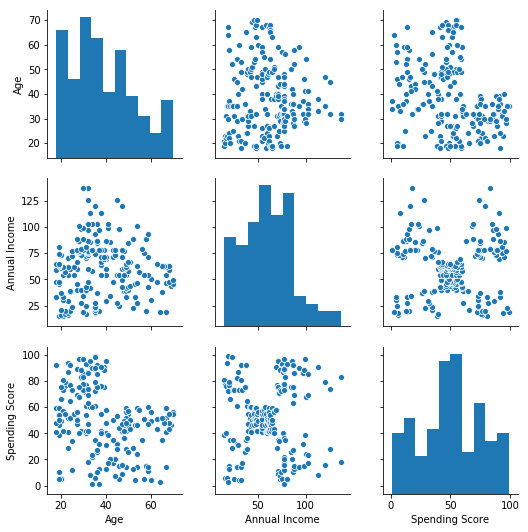

In [66]:
numerical_feature = [col for col in df.columns if df[col].dtypes == 'int64']

# numerical data distribution, outlier 확인 
for col in numerical_feature:
    sns.distplot(df.loc[df[col], col])
    plt.title(col)
    plt.show()
    
    df[col].plot(kind = 'box', color = 'red')
    plt.show()
# outlier도 거의 없고, 분포도 어느정도 퍼져있음을 확인    

# 데이터간 분포 관계 확인
sns.pairplot(df[numerical_feature], x_vars = numerical_feature, y_vars=numerical_feature)
plt.show()
# Anuual income과 Spending score 관계에 있어서 어느정도 clustering이 존재함을 확인

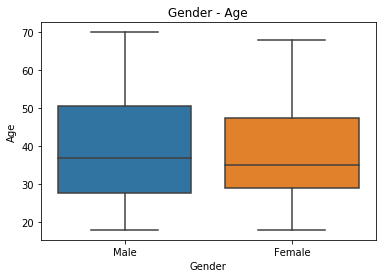

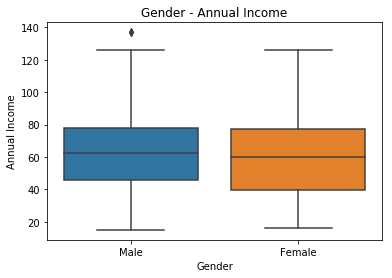

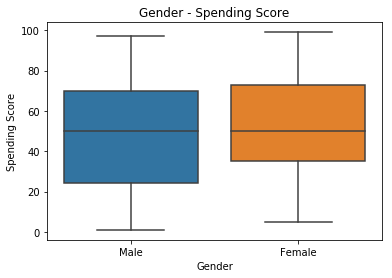

In [67]:
# 성별에 따른 numerical data 확인
for col in numerical_feature:
    sns.boxplot(x='Gender', y = col, data = df)
    plt.title('Gender - {}' .format(col))
    plt.show()
# 성별간 차이가 크지 않고, 잘 퍼져있음을 확인

In [68]:
# 카테고리 데이터 처리
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['Gender'] = le.fit_transform(df['Gender'])

# 1 = male, 0 = female

df.head()

,Gender,Age,Annual Income,Spending Score
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


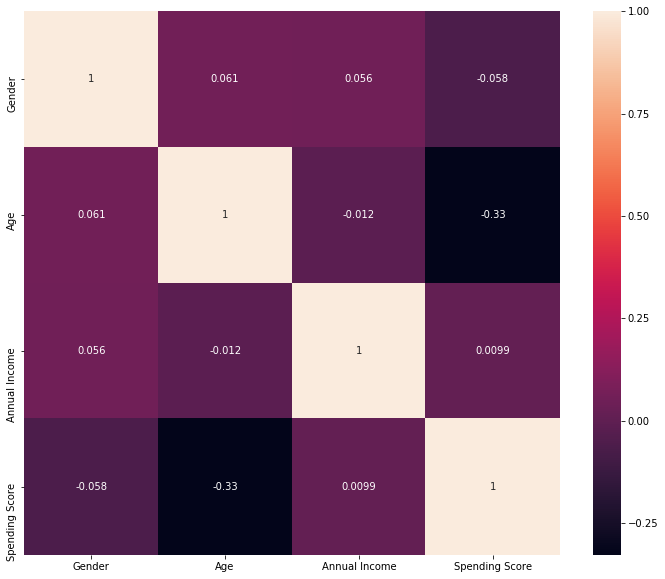

In [69]:

# correlation
# calculate the correlation matrix
corr = df.corr()
# adjust matrix size to (12, 10)
plt.subplots( figsize =( 12 , 10 ) )

# plot the correlation heatmap
sns.heatmap(corr,
        annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# Age와 Spending score의 약간의 반비례적인 관계 확인

In [70]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
#scaler = RobustScaler()
#scaler = MinMaxScaler()
scaler = MaxAbsScaler()
#scaler = StandardScaler()
df[numerical_feature] = scaler.fit_transform(df[numerical_feature])

print(df)

# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['Component1','Component2','Component3'])

# 이전 결과에서 성별이 클러스터를 완전히 반으로 나눠버렸다.
# 하지만 고객의 소비성향을 보고 마케팅 전략을 구상하는 것이 목표므로 성별로만 나뉘어져서는 안된다.
# 성별을 먼저 나누고 학습해보자.
dfgf = df[df.Gender == 'female'] # DataFrame gender female
dfgm = df[df.Gender == 'male'] # DataFrame gender male

from sklearn.cluster import KMeans
# 성별에 따른 결과 리스트
df_gender = []

for gender in range(2):
    print(gender)
    dfg = df[df.Gender == gender]
    dfg = dfg.reset_index(drop=True)

    kmeans = KMeans(n_clusters = 5, random_state = 0).fit_predict(dfg)
    cluster = pd.DataFrame(kmeans, columns=['cluster'])

    result = pd.concat([dfg, cluster], axis = 1)
    df_gender.append(result)
    print(result)

# sns.scatterplot(x = "principal component 1", y = "principal component 2", hue = "cluster", data = result)

     Gender       Age  Annual Income  Spending Score
0         1  0.271429       0.109489        0.393939
1         1  0.300000       0.109489        0.818182
2         0  0.285714       0.116788        0.060606
3         0  0.328571       0.116788        0.777778
4         0  0.442857       0.124088        0.404040
5         0  0.314286       0.124088        0.767677
6         0  0.500000       0.131387        0.060606
7         0  0.328571       0.131387        0.949495
8         1  0.914286       0.138686        0.030303
9         0  0.428571       0.138686        0.727273
10        1  0.957143       0.138686        0.141414
11        0  0.500000       0.138686        1.000000
12        0  0.828571       0.145985        0.151515
13        0  0.342857       0.145985        0.777778
14        1  0.528571       0.145985        0.131313
15        1  0.314286       0.145985        0.797980
16        0  0.500000       0.153285        0.353535
17        1  0.285714       0.153285        0.

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


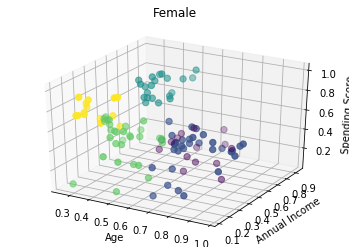

0
<class 'pandas.core.series.Series'>
<class 'int'>
1
<class 'pandas.core.series.Series'>
<class 'int'>
2
<class 'pandas.core.series.Series'>
<class 'int'>
3
<class 'pandas.core.series.Series'>
<class 'int'>
4
<class 'pandas.core.series.Series'>
<class 'int'>


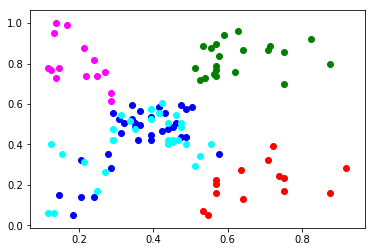

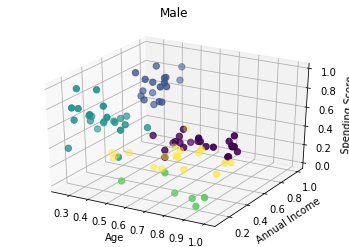

0
<class 'pandas.core.series.Series'>
<class 'int'>
1
<class 'pandas.core.series.Series'>
<class 'int'>
2
<class 'pandas.core.series.Series'>
<class 'int'>
3
<class 'pandas.core.series.Series'>
<class 'int'>
4
<class 'pandas.core.series.Series'>
<class 'int'>


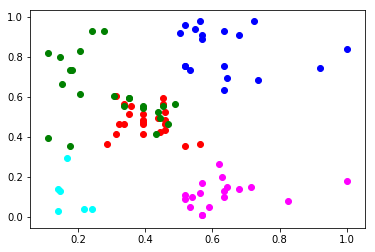

In [93]:
from mpl_toolkits.mplot3d import Axes3D

for gender in range(len(df_gender)):
    result = df_gender[gender]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(result['Age'], result['Annual Income'],result['Spending Score'], c = result['cluster'], s = 40)
    
    if gender == 0:
        title = "Female"
    else:
        title = "Male"
        
    ax.title.set_text(title)
    
    ax.set_xlabel('Age')
    ax.set_ylabel('Annual Income')
    ax.set_zlabel('Spending Score')
    plt.show()
    
    color_list = ['red', 'blue', 'green', 'cyan', 'magenta']
    
    for cluster_number in range(len(color_list)):
        temp = result[result['cluster'] == cluster_number]
        plt.scatter(temp['Annual Income'], temp['Spending Score'], c = color_list[cluster_number], label = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5', 'Cluster 6'])
    plt.show()
    

In [ ]:
plt.scatter()

In [ ]:
# gender로 클러스터링 해버리니깐 이렇게 클러스터의 가장 큰 잣y해보는 게 더 좋은 결과가 나올 듯?

# for gen in result['Gender'].unique():
#     gender_fix_data = result[result['Gender']==gen]
#     from mpl_toolkits.mplot3d import Axes3D
#     print(gender_fix_data)
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
    

#     ax.scatter(gender_fix_data['Age'], gender_fix_data['Annual Income'],gender_fix_data['Spending Score'], c = gender_fix_data['cluster'], s = 40)
#     ax.set_xlabel('Age')
#     ax.set_ylabel('Annual Income')
#     ax.set_zlabel('Spending Score')
#     plt.show()
#  #   plt.scatter(gender_fix_data['Component1'], gender_fix_data['Component2'])
    